In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

In [3]:
df = pd.read_csv('car_fuel_efficiency.csv')

In [5]:
df.head(3)

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341


In [7]:
df.isna().sum()   ## all null values are in numerical columns

engine_displacement      0
num_cylinders          482
horsepower             708
vehicle_weight           0
acceleration           930
model_year               0
origin                   0
fuel_type                0
drivetrain               0
num_doors              502
fuel_efficiency_mpg      0
dtype: int64

In [7]:
## Fill Null Values with 0
df.fillna(0, inplace=True)

In [9]:
df.isna().sum()

engine_displacement    0
num_cylinders          0
horsepower             0
vehicle_weight         0
acceleration           0
model_year             0
origin                 0
fuel_type              0
drivetrain             0
num_doors              0
fuel_efficiency_mpg    0
dtype: int64

### Train / Validation / Test  datasets

In [11]:
### Train / Validation / Test  datasets

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

In [13]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

y_train = df_train['fuel_efficiency_mpg'].values
y_val = df_val['fuel_efficiency_mpg'].values
y_test = df_test['fuel_efficiency_mpg'].values

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

In [15]:
## Initiate Dictionary Vectorizer
dv = DictVectorizer(sparse=True)

In [17]:
## Create Dictionary of feature dataset & Vectorize dataset
train_dicts = df_train.to_dict(orient='records')

## Vectorize dataset
X_train = dv.fit_transform(train_dicts)

## Vectorize validation dataset
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [27]:
y_train

array([15.3014754 , 15.33121466, 15.33667895, ..., 15.18828665,
       17.3967514 , 16.16090373])

# QUESTION 1 build a Decision Tree Regressor

In [19]:
## Create Decision Tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import export_text

In [21]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [23]:
## Show the feature used to split the Tree Node
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]



# QUESTION 2 -- BUILD A RANDOM FOREST REGRESSOR

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import export_text
import numpy as np

In [27]:
rf = RandomForestRegressor(n_estimators=10, random_state=1)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)

mse = mean_squared_error(y_val, y_pred)

print(f'rmse of Random Forest Regressor model is: {np.sqrt(mse)}')

rmse of Random Forest Regressor model is: 0.4595777223092726


# QUESTION 3 Experiment with the "n_estimators" parameter

In [90]:
estimators = list(range(10, 201, 10))

estimators[-1]

200

In [31]:
## loop through n_estimators to find best number of trees in random forest to produce best RMSE
estimators = list(range(10, 201, 10))

scores = []

for e in tqdm(estimators):
    rf = RandomForestRegressor(n_estimators=e, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    rmse = round(np.sqrt(mse),3)
    scores.append((e, rmse))



  0%|          | 0/20 [00:00<?, ?it/s]

In [33]:
scores[:3]

[(10, 0.46), (20, 0.454), (30, 0.452)]

In [39]:
dfx = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

dfx

,n_estimators,rmse
0,10,0.460
1,20,0.454
2,30,0.452
3,40,0.449
4,50,0.447
5,60,0.445
6,70,0.445
7,80,0.445
8,90,0.445
9,100,0.445


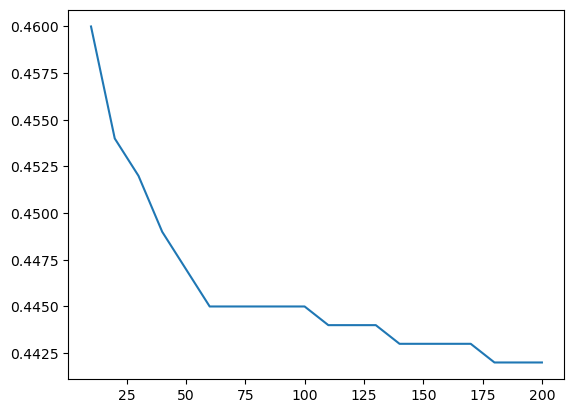

In [43]:
plt.plot(dfx.n_estimators, dfx.rmse)


# QUESTION 4 --   tune hyperparameter "max_depth" using same set of possible "n_estimators" from question 3

In [52]:
scores = []

for m in [10, 15, 20, 25]:
    for e in tqdm(estimators):
        rf = RandomForestRegressor(n_estimators=e, max_depth=m, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
    
        y_pred = rf.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        rmse = round(np.sqrt(mse),3)
        scores.append((m, e, rmse))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [54]:
## fit all model results into Dataframe
dfx = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'rmse'])

dfx

,max_depth,n_estimators,rmse
0,10,10,0.450
1,10,20,0.447
2,10,30,0.445
3,10,40,0.443
4,10,50,0.442
...,...,...,...
75,25,160,0.443
76,25,170,0.443
77,25,180,0.442
78,25,190,0.443


In [58]:
## Calclate mean RMSE per "max_depth"

dfx.groupby('max_depth').agg({'rmse':'mean'})

,rmse
max_depth,
10,0.44185
15,0.44550
20,0.44615
25,0.44590


In [62]:
## ANSWER = The best max_depth parameter based on average RMSE after iteration of various n_estimators is 
    ## max_depth = 10   since that max_depth produces the lowest RMSE

# QUESTION 5  -- Extract feature importance information from tree based model

In [67]:
## Instantiate Random Forest Model
rf = RandomForestRegressor(n_estimators=10, max_depth=20, n_jobs=-1, random_state=1)

In [81]:
list(dv.get_feature_names_out())

['acceleration',
 'drivetrain=All-wheel drive',
 'drivetrain=Front-wheel drive',
 'engine_displacement',
 'fuel_type=Diesel',
 'fuel_type=Gasoline',
 'horsepower',
 'model_year',
 'num_cylinders',
 'num_doors',
 'origin=Asia',
 'origin=Europe',
 'origin=USA',
 'vehicle_weight']

In [71]:
## Train Model
rf.fit(X_train, y_train)

## Extract feature_importances
rf.feature_importances_

array([1.14797006e-02, 3.57108549e-04, 3.45384113e-04, 3.27279191e-03,
       3.25424323e-04, 3.60383601e-04, 1.59978977e-02, 3.21230009e-03,
       2.34334695e-03, 1.63498954e-03, 4.62246496e-04, 5.18739639e-04,
       5.39721689e-04, 9.59149965e-01])

In [85]:
dfx = pd.DataFrame(columns=['feature', 'importance'])

## Set list to columns
dfx['feature'] = list(dv.get_feature_names_out())
dfx['importance'] = (rf.feature_importances_).tolist()
dfx

,feature,importance
0,acceleration,0.011480
1,drivetrain=All-wheel drive,0.000357
2,drivetrain=Front-wheel drive,0.000345
3,engine_displacement,0.003273
4,fuel_type=Diesel,0.000325
5,fuel_type=Gasoline,0.000360
6,horsepower,0.015998
7,model_year,0.003212
8,num_cylinders,0.002343
9,num_doors,0.001635


In [87]:
## Sort by feature_importance to determine the highest score

dfx.sort_values('importance', ascending=False)    ## ANSWER = vehicle_weight is most important feature

,feature,importance
13,vehicle_weight,0.959150
6,horsepower,0.015998
0,acceleration,0.011480
3,engine_displacement,0.003273
7,model_year,0.003212
8,num_cylinders,0.002343
9,num_doors,0.001635
12,origin=USA,0.000540
11,origin=Europe,0.000519
10,origin=Asia,0.000462


# QUESTION 6  Train an XGBoost model

In [ ]:
## Install XGBoost
## Create DMatrix for Train and Validation
## Create a watchlist
## Train a model with these parameters for 100 rounds

In [23]:
import xgboost as xgb

In [25]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [27]:
## Watchlist
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [93]:
%%capture output


xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  evals=watchlist)

UsageError: Line magic function `%%capture` not found.


In [83]:
## Save output of watchlist split on each line
    ## view sample of the output list
parse_output = output.stdout.split('\n')
parse_output[:2]

['[0]\ttrain-rmse:1.81393\tval-rmse:1.85444',
 '[1]\ttrain-rmse:1.31919\tval-rmse:1.35353']

In [89]:
## use Regex positive lookbehind 
    ## save only element returned in lookbehind search
val_rmse =re.search(r"(?<=val-rmse:).+", parse_output[-2])[0]

print(f' validation rmse on XGBoost model using "eta" learning rate 0.3 is: {val_rmse}')

 validation rmse on XGBoost model using "eta" learning rate 0.3 is: 0.45018


In [ ]:
### TRAIN XGBOOST MODEL WITH "ETA" LEARNING RATE 0.1
    ### ALL OTHER PARAMETERS BEING THE SAME AS PREV MODEL

In [103]:
%%capture output2


xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  evals=watchlist)

In [131]:
output2.stdout.split('\n')[:2]

['[0]\ttrain-rmse:2.28944\tval-rmse:2.34561',
 '[1]\ttrain-rmse:2.07396\tval-rmse:2.12434']

In [109]:
## Store watchlist output of XGBoost model and split on each line
parse_output2 = output2.stdout.split('\n')

parse_output2[:3]

['[0]\ttrain-rmse:2.28944\tval-rmse:2.34561',
 '[1]\ttrain-rmse:2.07396\tval-rmse:2.12434',
 '[2]\ttrain-rmse:1.88066\tval-rmse:1.92597']

In [123]:
## Save final XGBoost model RMSE result
print(parse_output2[-2])

val_rmse2 = re.search(r"(?<=val-rmse:).+", parse_output2[-2])[0]
print(f' validation rmse on XGBoost model using "eta" learning rate 0.1 is: {val_rmse2}')

[99]	train-rmse:0.30419	val-rmse:0.42623
 validation rmse on XGBoost model using "eta" learning rate 0.1 is: 0.42623


In [125]:
### COMPARE RMSE BETWEEN BOTH MODELS
print(f' validation rmse on XGBoost model using "eta" learning rate 0.3 is: {val_rmse}')
print(f' validation rmse on XGBoost model using "eta" learning rate 0.1 is: {val_rmse2}')

 validation rmse on XGBoost model using "eta" learning rate 0.3 is: 0.45018
 validation rmse on XGBoost model using "eta" learning rate 0.1 is: 0.42623
